<a href="https://colab.research.google.com/github/JumanaWanass/Face-Recognition-with-PCA-and-KNN/blob/main/Face_Recognition_with_PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Face Recognition with Dimensionality Reduction and KNN

## 1. Data Preprocessing

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"


In [ ]:
!unzip archive.zip

### 1.1 Importing libraries

- `cupy`: GPU-accelerated library for numerical computations, compatible with NumPy.
- `matplotlib`: Plotting library for creating visualizations in Python.
- `sklearn.neighbors`: Implements k-nearest neighbors algorithms for classification and regression.
- `GridSearchCV`: Part of scikit-learn, it performs exhaustive search over specified parameter values for an estimator.
- `train_test_split`: Function for splitting datasets into training and testing sets.
- `collections.defaultdict`: Dictionary subclass with a default value for new keys.
- `accuracy_score, precision_score, recall_score, f1_score`: Metrics for evaluating classification models.
- `confusion_matrix, ConfusionMatrixDisplay`: Tools for visualizing confusion matrices.
- `pandas`: Data manipulation and analysis library, providing data structures and functions.
- `numpy`: Fundamental package for scientific computing with Python.
- `seaborn`: Statistical data visualization based on matplotlib.
- `random`: Module for generating pseudorandom numbers.
- `cv2`: OpenCV library for computer vision tasks.


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from collections import defaultdict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,ConfusionMatrixDisplay
import pandas as pd
import numpy as np
import seaborn as sns
import random
import cv2
import os

In [ ]:
data_matrix = np.zeros((400,10304))
label_vector = np.zeros((400,1))

###1.2 Data Matrix formation and data split

In [ ]:
for i in range(1,41):
    for j in range(1,11):
        path_for_image = 's' + str(i) + "/" + str(j) + ".pgm"
        img = np.reshape(np.array(mpimg.imread(path_for_image)),(1,10304))
        data_matrix[(i-1)*10 + j - 1,:] = img
        label_vector[(i-1)*10 + j - 1] = i

In [ ]:
# Odd rows
x_train = data_matrix[::2]
y_train = label_vector[::2]

# Even rows
x_test = data_matrix[1::2]
y_test = label_vector[1::2]

print(x_train.shape)
print(x_test.shape)

(200, 10304)
(200, 10304)


## 2. PCA

### 2.1 Principal Component Analysis (PCA) Algorithm


#### 1. Standardize the Data


$ z_i = \frac{x_i - \mu_i}{\sigma_i} $

where  $\mu_i$ is the mean and $\sigma_i$ is the standard deviation of $x_i $.

### 2. Compute the Covariance Matrix


$Σ = \frac{1}{m} \sum_{i=1}^{m} (z^{(i)})^T \cdot z^{(i)} $

where $ m $ is the number of samples and $ z^{(i)} $ is the standardized feature vector of the $ i $-th sample.

### 3. Compute Eigenvectors and Eigenvalues



$Σ \cdot v = \lambda \cdot v $

where $v $ is the eigenvector and $ \lambda $ is the eigenvalue.

### 4. Sort Eigenvectors by Eigenvalues

Sort the eigenvectors in descending order based on their corresponding eigenvalues. This ensures that the principal components are ranked by the amount of variance they explain.

### 5. Select Principal Components

Choose the top $k$ eigenvectors to form the new feature space (where $ k $ is the desired number of dimensions for the reduced data).

### 6. Project Data onto the New Feature Space

Project the original data onto the selected principal components to obtain the reduced-dimensional representation of the data.

The reduced-dimensional data $ X_{\text{new}} $ is obtained by:

$ X_{\text{new}} = X \cdot W $

where $ X $ is the original standardized data and $ W $ is the matrix of selected eigenvectors.


### 2.2 Helping Functions

Creating the projection matrix:

In [ ]:
def ProjectionMatrix(D):
  cov = np.cov(D.T,bias=True)
  eigVal,eigVec = np.linalg.eigh(cov)
  idx = eigVal.argsort()[::-1] #getting indices that would sort eigenvalues descendingly
  eigVal = eigVal[idx]
  eigVec = eigVec[:,idx]
  return eigVal,eigVec

Creating the reduced basis

In [ ]:
def getReducedBasis(eigVal, eigVec, a):
    cumulativeSum = np.cumsum(eigVal[::-1])[::-1] #reverse cumulative sum
    Eigsum = np.sum(eigVal) #represents the total variance of data
    r = np.argwhere((cumulativeSum/Eigsum)>=a)[0][0] # Extracting the integer value
    return eigVec[:,:r+1]


PCA implemented on train set

In [ ]:
def PCA(x_train, a):
  eigVal,eigVec = ProjectionMatrix(x_train)
  Ur = getReducedBasis(eigVal, eigVec, a)
  x_train_projected = np.matmul(x_train, Ur)
  x_test_projected = np.matmul(x_test, Ur)
  return x_train_projected, x_test_projected

### 2.3 Model Evaluation Metrics

The following metrics are employed for evaluating the performance of the classification model:

- **Accuracy Score**: Measures the overall correctness of the model by comparing correctly predicted instances to the total instances.

- **Precision Score**: Indicates the proportion of true positive predictions among all positive predictions, providing insights into the model's precision in positive classifications.

- **Recall Score**: Also known as sensitivity or true positive rate, it assesses the model's ability to capture all relevant instances by measuring the ratio of true positives to the total actual positives.

- **F1 Score**: Harmonic mean of precision and recall, offering a balanced metric that considers both false positives and false negatives.


In [ ]:
Metrics = [precision_score, recall_score, f1_score]
MetricResults = defaultdict(list)
CVresults = defaultdict(list)
alpha_values = [0.8, 0.85, 0.9, 0.95]

###2.4 The KNN model

In [ ]:
def KNN(alpha_values, x_train, y_train, x_test, y_test, CVresults, MetricResults, Metrics):
    for a in alpha_values:
        x_train_projected, x_test_projected = PCA(x_train, a)
        # The following lines are related to training the KNN model on the data
        param = {'n_neighbors': list(range(1, 8, 2))}
        Knnclf = GridSearchCV(KNeighborsClassifier(), param, verbose=1)
        Knnclf.fit(x_train_projected, y_train.ravel())

        # The following lines are related to measuring our model's performance
        y_pred = Knnclf.best_estimator_.predict(x_test_projected)
        Knnclf.cv_results_['alpha'] = a
        CVresults['Result'].append(Knnclf.cv_results_)
        MetricResults['alpha'].append(str(a))
        MetricResults['accuracy_score'].append(accuracy_score(y_test, y_pred))

        for metric in Metrics:
            MetricResults[metric.__name__].append(metric(y_test, y_pred, average='macro'))

    # The following lines are for visualizing the results
    Res = pd.DataFrame.from_records(CVresults['Result'])
    Res = Res[['alpha', 'param_n_neighbors', 'mean_test_score']].explode(['mean_test_score', 'param_n_neighbors']).reset_index(drop=True)
    Res = Res.sort_values(['mean_test_score'], ascending=False)

    return CVresults, MetricResults, Res


## 3. Data Visualization

In [ ]:
CVresults, MetricResults, Res = KNN(alpha_values, x_train, y_train, x_test, y_test, CVresults, MetricResults, Metrics)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting 5 folds for each of 4 candidates, totalling 20 fits


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting 5 folds for each of 4 candidates, totalling 20 fits


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting 5 folds for each of 4 candidates, totalling 20 fits


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
Res

,alpha,param_n_neighbors,mean_test_score
2,0.80,5,0.145
6,0.85,5,0.145
10,0.90,5,0.145
14,0.95,5,0.145
3,0.80,7,0.14
7,0.85,7,0.14
11,0.90,7,0.14
15,0.95,7,0.14
1,0.80,3,0.105
5,0.85,3,0.105


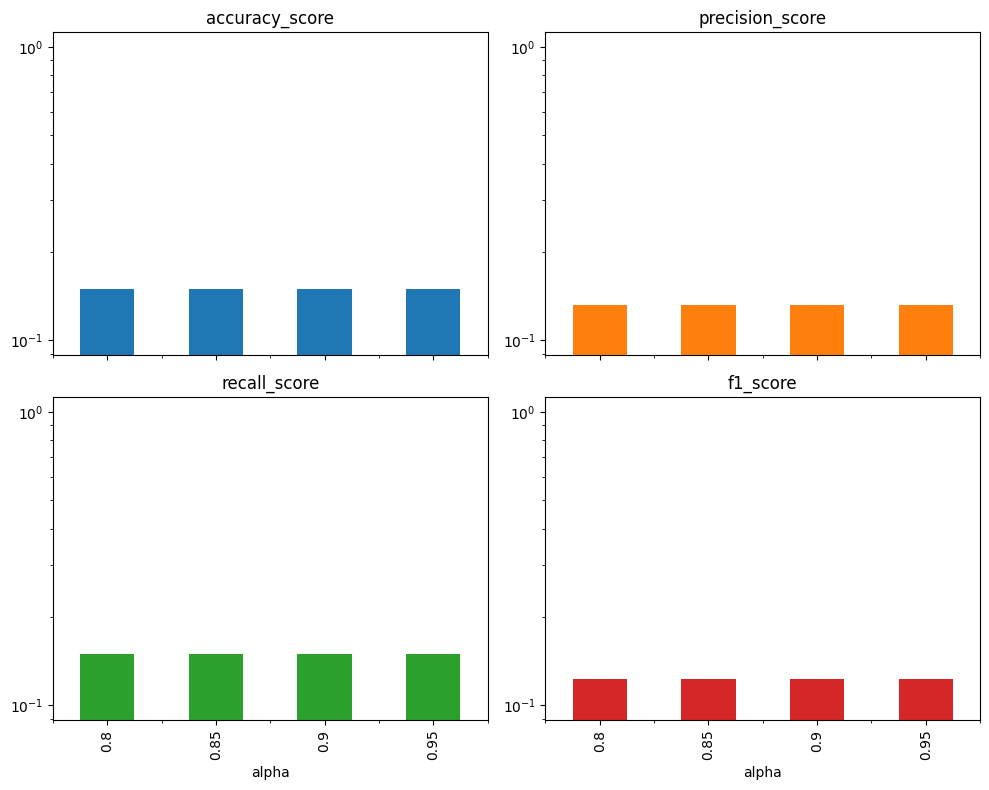

In [ ]:
ResultDF = pd.DataFrame.from_dict(MetricResults)

ax = ResultDF.plot.bar(x='alpha', subplots=True, layout=(2, 2), figsize=(10, 8), logy=True, legend=None)    #using log scale to show large differences
#ax = ResultDF.plot.bar(x='alpha', subplots=True, layout=(2, 2), figsize=(10, 8), ylim=(0.5, 1),legend=None)

plt.tight_layout()
plt.show()

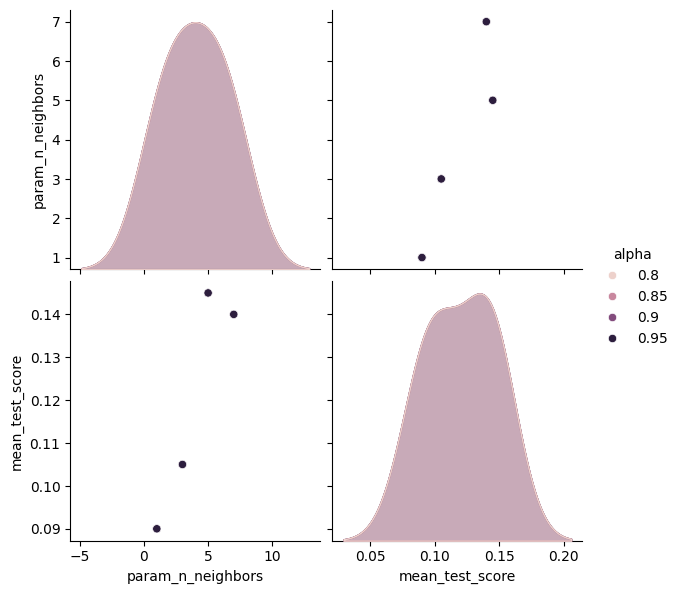

In [ ]:
visualization_data = Res[['alpha', 'param_n_neighbors', 'mean_test_score']]

sns.pairplot(visualization_data, hue='alpha', diag_kind='kde', height=3)
plt.show()


## Bonus 70 30 split

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(data_matrix, label_vector, test_size=0.3, stratify=label_vector)
#x_train = np.asarray(x_train)
#x_test = np.asarray(x_test)
#y_train = np.asarray(y_train)

#y_test = np.asarray(y_test)

In [ ]:
Metrics = [precision_score, recall_score, f1_score]
MetricResults = defaultdict(list)
CVresults = defaultdict(list)
CVresults, MetricResults, Res = KNN(alpha_values, x_train, y_train, x_test, y_test, CVresults, MetricResults, Metrics)
Res

Fitting 5 folds for each of 4 candidates, totalling 20 fits


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting 5 folds for each of 4 candidates, totalling 20 fits


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting 5 folds for each of 4 candidates, totalling 20 fits


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting 5 folds for each of 4 candidates, totalling 20 fits


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,alpha,param_n_neighbors,mean_test_score
3,0.80,7,0.139286
7,0.85,7,0.139286
11,0.90,7,0.139286
15,0.95,7,0.139286
1,0.80,3,0.132143
5,0.85,3,0.132143
9,0.90,3,0.132143
13,0.95,3,0.132143
0,0.80,1,0.125
4,0.85,1,0.125


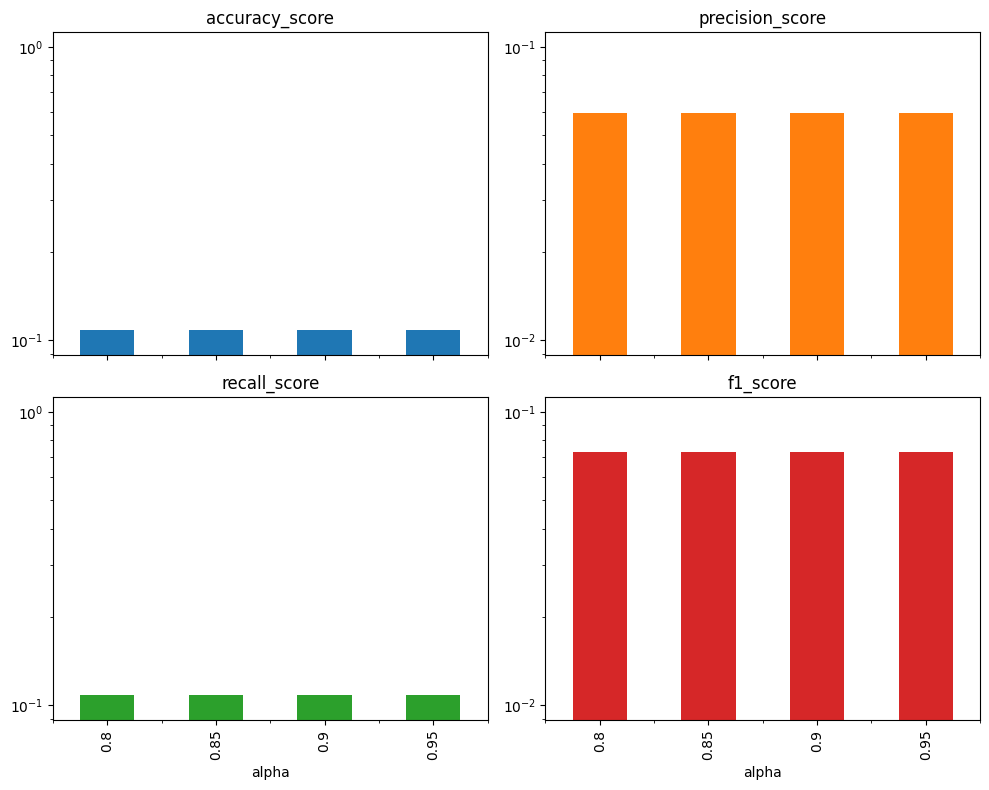

In [ ]:
ResultDF = pd.DataFrame.from_dict(MetricResults)
# Create a bar plot with separate subplots for each metric
numeric_cols = ResultDF.select_dtypes(include=[np.number])
ax = ResultDF.plot.bar(x='alpha', subplots=True, layout=(2, 2), figsize=(10, 8), logy=True, legend=None)
#ax = ResultDF.plot.bar(x='alpha', subplots=True, layout=(2, 2), figsize=(10, 8), ylim=(0.5, 1),legend=None)

plt.tight_layout()
plt.show()

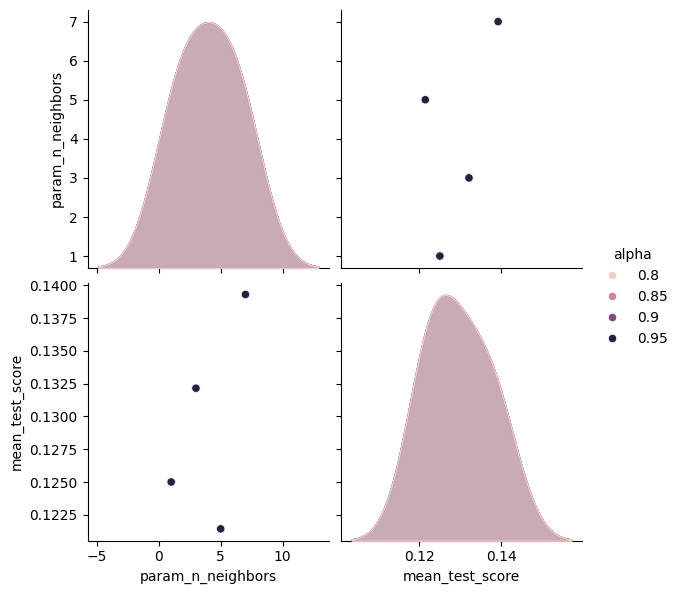

In [ ]:
visualization_data = Res[['alpha', 'param_n_neighbors', 'mean_test_score']]

# Create a pair plot to visualize relationships
sns.pairplot(visualization_data, hue='alpha', diag_kind='kde', height=3)
plt.show()


# Classifying Faces vs Non Faces

In [ ]:
!unzip pokemon.zip

In [ ]:
data_matrix_pokemon = np.zeros((400,10304))

In [ ]:
PokemonNames = os.listdir('images/images/')
for _ in range(409):
    index = random.randint(0, len(PokemonNames) - 1)
    PokemonNames.pop(index)

In [ ]:
for i, pokemon in enumerate(PokemonNames):
    path_for_image = 'images/images/' + pokemon
    image = cv2.imread(path_for_image, cv2.IMREAD_GRAYSCALE)
    resized = cv2.resize(image, (92, 112))
    img = np.array(resized).flatten()
    cupy_image = np.asarray(img)
    data_matrix_pokemon[i, :] = cupy_image

data_matrix = np.zeros((400,10304))


In [ ]:
print(data_matrix_pokemon.shape)

In [ ]:
merged_data = np.concatenate((data_matrix, data_matrix_pokemon), axis=0) #stacking the rows vertically

# Create labels vector
labels_data = np.ones((data_matrix.shape[0],), dtype=np.float32)
labels_pokemon = np.zeros((data_matrix_pokemon.shape[0],), dtype=np.float32)
labels = np.concatenate((labels_data, labels_pokemon))

# Shuffle the data and labels in unison
indices = np.arange(merged_data.shape[0])
np.random.shuffle(indices)  #in-place shuffling

shuffled_data = merged_data[indices]
shuffled_labels = labels[indices]

# Split into train and test sets
x_train, x_test, y_train, y_test = train_test_split(shuffled_data, shuffled_labels, test_size=0.2, random_state=42)

In [ ]:
Metrics = [precision_score, recall_score, f1_score]
MetricResults = defaultdict(list)
CVresults = defaultdict(list)
alpha_values = [0.8, 0.85, 0.9, 0.95]

In [ ]:
eigVal, eigVec = ProjectionMatrix(x_train)
CVresults, MetricResults, Res = KNN(alpha_values, x_train, y_train, x_test, y_test, CVresults, MetricResults, Metrics)

In [ ]:
ResultDF = pd.DataFrame.from_dict(MetricResults)

#ax = ResultDF.plot.bar(x='alpha', subplots=True, layout=(2, 2), figsize=(10, 8), logy=True, legend=None)
ax = ResultDF.plot.bar(x='alpha', subplots=True, layout=(2, 2), figsize=(10, 8), ylim=(0.5, 1),legend=None)

plt.tight_layout()
plt.show()

**Varying number of non faces samples**

In [ ]:
num_pokemon_range = range(450, 801, 50)
# PokemonNames = os.listdir('images/images/')
accuracy_results = []

for num_pokemon_images in num_pokemon_range:
    for _ in range(num_pokemon_images):
      indexxx = random.randint(0, len(PokemonNames) - 1)
      PokemonNames.pop(indexxx)

    for i, pokemon in enumerate(PokemonNames):
      path_for_image = 'images/images/' + pokemon
      image = cv2.imread(path_for_image, cv2.IMREAD_GRAYSCALE)
      resized = cv2.resize(image, (92, 112))
      img = np.array(resized).flatten()
      cupy_image = np.asarray(img)
      data_matrix_pokemon[i, :] = cupy_image


    merged_data = np.concatenate((data_matrix, data_matrix_pokemon), axis=0) #stacking the rows vertically

    # Create labels vector
    labels_data = np.ones((data_matrix.shape[0],), dtype=np.float32)
    labels_pokemon = np.zeros((data_matrix_pokemon.shape[0],), dtype=np.float32)
    labels = np.concatenate((labels_data, labels_pokemon))

    # Shuffle the data and labels in unison
    indices = np.arange(merged_data.shape[0])
    np.random.shuffle(indices)  #in-place shuffling

    shuffled_data = merged_data[indices]
    shuffled_labels = labels[indices]

    # Split into train and test sets
    x_train, x_test, y_train, y_test = train_test_split(shuffled_data, shuffled_labels, test_size=0.2, random_state=42)


    Metrics = [precision_score, recall_score, f1_score]
    MetricResults = defaultdict(list)
    CVresults = defaultdict(list)
    alpha_values = [0.8, 0.85, 0.9, 0.95]

    eigVal, eigVec = ProjectionMatrix(x_train)
    CVresults, MetricResults, Res = KNN(alpha_values, x_train, y_train, x_test, y_test, CVresults, MetricResults, Metrics)
    accuracy= MetricResults['accuracy_score']
    # Append the accuracy to the results list
    accuracy_results.append(accuracy)

# Plotting the results
plt.plot(num_pokemon_range, accuracy_results, marker='o')
plt.xlabel('Number of Pokémon Images in Training Data')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Pokémon Images')
plt.show()

In [ ]:
num_pokemon_range = range(450, 801, 50)
accuracy_results = []

original_PokemonNames = os.listdir('images/images/')  # Create a copy of the original list

for num_pokemon_images in num_pokemon_range:
    PokemonNames = original_PokemonNames.copy()  # Use the copy in each iteration
    for _ in range(num_pokemon_images):
        indexxx = random.randint(0, len(PokemonNames) - 1)
        PokemonNames.pop(indexxx)

    for i, pokemon in enumerate(PokemonNames):
        path_for_image = 'images/images/' + pokemon
        image = cv2.imread(path_for_image, cv2.IMREAD_GRAYSCALE)
        resized = cv2.resize(image, (92, 112))
        img = np.array(resized).flatten()
        cupy_image = np.asarray(img)
        data_matrix_pokemon[i, :] = cupy_image

    merged_data = np.concatenate((data_matrix, data_matrix_pokemon), axis=0)

    labels_data = np.ones((data_matrix.shape[0],), dtype=np.float32)
    labels_pokemon = np.zeros((data_matrix_pokemon.shape[0],), dtype=np.float32)
    labels = np.concatenate((labels_data, labels_pokemon))

    indices = np.arange(merged_data.shape[0])
    np.random.shuffle(indices)

    shuffled_data = merged_data[indices]
    shuffled_labels = labels[indices]

    x_train, x_test, y_train, y_test = train_test_split(shuffled_data, shuffled_labels, test_size=0.2, random_state=42)

    Metrics = [precision_score, recall_score, f1_score]
    MetricResults = defaultdict(list)
    CVresults = defaultdict(list)
    alpha_values = [0.8, 0.85, 0.9, 0.95]

    CVresults, MetricResults, Res = KNN(alpha_values, x_train, y_train, x_test, y_test, CVresults, MetricResults, Metrics)
    accuracy = MetricResults['accuracy_score']
    accuracy_results.append(accuracy)

# Plotting the results
plt.plot(num_pokemon_range, accuracy_results, marker='o')
plt.xlabel('Number of Pokémon Images in Training Data')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Pokémon Images')
plt.show()
